In [6]:
%load_ext dotmagic

In [7]:
import numpy as np
import pandas as pd

%run settings/plt_settings.ipynb
%run settings/db_connect.ipynb

import pickle
with open('data/predictions/vsl2b_valid.pickle', 'rb') as f:
    vsl2b_valid = pickle.load(f)
with open('data/predictions/vsl2b_random.pickle', 'rb') as fr:
    vsl2b_random = pickle.load(fr)
with open('data/predictions/vsl2b_uniform.pickle', 'rb') as fu:
    vsl2b_uniform = pickle.load(fu)

def is_disorderd_40(raw, regions):
    return any(l >=40 for _,_,l in regions)

def linear_limit(l): # preslikava region izmedju 30-80 
    if l > 120:  return 40
    if l <  30:  return l
    
    return  (l-30)/(120-30)*10 + 30

def is_disorderd_40_smart(raw, regions):
    return any(l >=linear_limit(len(raw)) for _,_,l in regions)

xs = np.arange(1, 400)
plt.plot(xs, [linear_limit(x) for x in xs])

valid_proteins_df = pd.DataFrame( [(ac, len(raw)) for (ac,raw,_) in vsl2b_valid], columns=['ac', 'len'] ).set_index('ac')
valid_proteins_df['dis40'] = [is_disorderd_40(raw, regions) for _,raw,regions in vsl2b_valid]
valid_proteins_df['dis40_random'] = [is_disorderd_40(raw, regions) for _,raw,regions in vsl2b_random]
valid_proteins_df['dis40_uniform'] = [is_disorderd_40(raw, regions) for _,raw,regions in vsl2b_uniform]
valid_proteins_df['dis_smart'] = [is_disorderd_40_smart(raw, regions) for _,raw,regions in vsl2b_valid]
valid_proteins_df['dis_smart_random'] = [is_disorderd_40_smart(raw, regions) for _,raw,regions in vsl2b_random]

dis40 = valid_proteins_df
valid_proteins_df.head()

# $P_L$

In [8]:
dis40 = sql(r"""select * from valid_proteins where len >= 40""")
dis40.head()

,len,dis40,dis40_random,dis40_uniform,dis_smart,dis_smart_random
ac,,,,,,
A2AC93,623,True,False,False,True,False
A2AD83,703,True,True,False,True,True
A2AGH6,2190,True,True,False,True,True
A2AJ88,1352,True,True,False,True,True
A2AJK6,2986,True,True,False,True,True


In [9]:
def generate_PL(df, column):
    from functools import lru_cache
    
    df = pd.DataFrame(df[['len', column]])
   
    @lru_cache(maxsize=None)
    def _PL(L):
        eps = round(0.1*L)
        return df[ (df.len >= L-eps) & (df.len <= L+eps) ].mean()[column]
        
    _PL.df = df
    _PL.raw = df.groupby('len').mean()  # da bi kasnije mogao da se referisem na njega
    
    return _PL
  
PL = generate_PL(dis40, 'dis40')
PL_random = generate_PL(dis40, 'dis40_random')
PL_uniform = generate_PL(dis40, 'dis40_uniform')
PL_smart = generate_PL(dis40, 'dis_smart')
PL_smart_random = generate_PL(dis40, 'dis_smart_random')

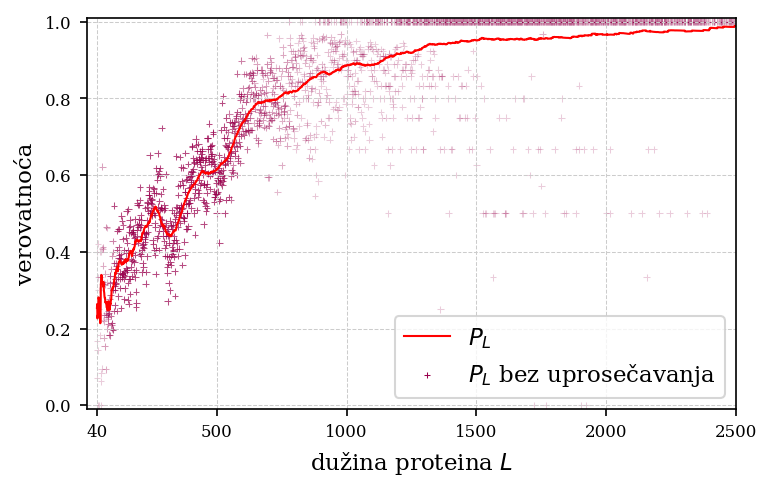

In [10]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])

ax.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')

xs_count = PL.df.groupby('len').count().dis40
xs_color = [(0.6,0,0.3, max(min(n/100,0.7),0.2) ) for n in xs_count]
ax.scatter( PL.raw.index,  PL.raw.dis40, label='$P_L$ bez uprosečavanja'
            , marker='+', color=xs_color, linewidth=0.5, s=10)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

# ax.set_title('Zavisnost neuređenosti i dužine proteina')
ax.set_xlabel("dužina proteina $L$")
ax.set_ylabel("verovatnoća")


leg =ax.legend()
leg.legendHandles[1].set_color((0.6,0,0.3))

plt.savefig('plots/PL_F.pdf', dpi=300)

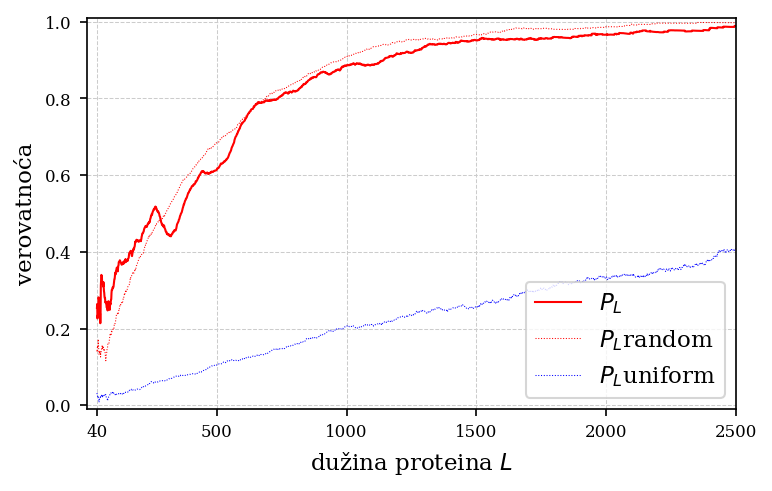

In [10]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])
ys_random = np.array([PL_random(x) for x in xs])
ys_uniform = np.array([PL_uniform(x) for x in xs])
#ys_smart = np.array([PL_smart(x) for x in xs])
#ys_smart_random = np.array([PL_smart_random(x) for x in xs])


plt.plot(xs, ys, 'r', linewidth=1, label='$P_L$')
plt.plot(xs, ys_random, 'r:', linewidth=0.5, label='$P_L$random')
plt.plot(xs, ys_uniform, 'b:', linewidth=0.5, label='$P_L$uniform')
#plt.plot(xs, ys_smart, 'g', linewidth=0.5, label='$P_L$smart')
#plt.plot(xs, ys_smart_random, 'g:', linewidth=0.5, label='$P_L$smart_random')



ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

#ax.set_title('Zavisnost neurđenosti i dužine za slučajno generisane proteine')
ax.set_xlabel("dužina proteina $L$")
ax.set_ylabel("verovatnoća")

plt.legend(loc='lower right' )

plt.savefig('plots/PL_F_cmp.pdf', dpi=300)

# Dis

In [14]:
Fj_kw_raw = sql(r"""
select kw, name
     , count(kw) n
     , avg(len) avg_len
     , avg(dis40::int) avg_dis
     , array_agg(len) length_list
     
from valid_proteins
    join prot2kw on ac=prot
    join keywords on keywords.ac=prot2kw.kw

where true
  and category = 'KW-9992' -- Molecular function
  and len >=40

group by (kw, name)
""")
Fj_kw_raw.head()

,name,n,avg_len,avg_dis,length_list
kw,,,,,
KW-0008,Acetylcholine receptor inhibiting toxin,12,70.750000,0.250000,"[109, 69, 64, 60, 58, 111, 62, 69, 64, 64, 60,..."
KW-0009,Actin-binding,837,974.918757,0.768220,"[730, 1538, 492, 1141, 490, 1141, 821, 1315, 1..."
KW-0010,Activator,2574,600.510101,0.878788,"[238, 187, 532, 201, 775, 345, 376, 2581, 1310..."
KW-0012,Acyltransferase,867,531.583622,0.422145,"[1189, 381, 484, 512, 184, 445, 323, 168, 170,..."
KW-0022,Alpha-amylase inhibitor,3,166.333333,0.000000,"[146, 153, 200]"


In [15]:
%load_ext cython

In [16]:
%%cython -f
from libc.stdlib cimport rand, srand, RAND_MAX

srand(0);
  
cdef float random1():
    return rand()/float(RAND_MAX)

def calcYj(PL_list):
    cdef int i = 0
    cdef float l
    for PL_instance in PL_list:
        if random1() < PL_instance:
            i+=1
    return i/len(PL_list)

In [17]:
def calc_stat(Fj, PL):
    from tqdm import tqdm

    stat_info = []

    for index, row in tqdm(Fj.iterrows(), total=len(Fj), ):
        PL_list = [ PL(l) for l in row['length_list']]
        Yj_realisations = np.array( [calcYj(PL_list) for _ in range(1000)] )
        p = (Yj_realisations > row.avg_dis).mean()  # empirical

        p = 1-p # ovo moram da hakujem da  bi bse poklapalo sa tabelama u radu, ne znam zasto je tako ???

        Yj_mean = Yj_realisations.mean()
        Yj_std  = Yj_realisations.std() #or 0.0000001

        z = (row.avg_dis - Yj_mean) / Yj_std
        #pp = 1/2*(1 - math.erf(z/2))
        #print('go:', go, 'p:', p, mean, std, z, 'pp:', pp)   
        stat_info.append((index, z, p))

    stat_info = pd.DataFrame(stat_info, columns=['index', 'z', 'p']).set_index('index')
    return  pd.DataFrame(Fj[Fj.columns[:-1]]).join(stat_info)

In [45]:
Fj_kw_stat = calc_stat(Fj_kw_raw, PL)

100%|██████████| 186/186 [00:18<00:00,  9.86it/s]


In [98]:
Fj_kw_stat = pd.read_csv('data/tmp/FJ_kw_stat.csv', index_col='kw')

In [99]:
Fj_kw_valid = (Fj_kw_stat.query(' p<0.05 or p>0.95')
                         .sort_values('z', ascending=False))
Fj_kw_valid.head()

,name,n,avg_len,avg_dis,z,p
kw,,,,,,
KW-0238,DNA-binding,6518,546.531912,0.871126,46.904973,1.0
KW-0217,Developmental protein,3897,655.208622,0.859379,31.096980,1.0
KW-0010,Activator,2574,600.510101,0.878788,28.115824,1.0
KW-0678,Repressor,1988,589.294769,0.852113,22.628029,1.0
KW-0694,RNA-binding,2728,575.764296,0.763563,16.617519,1.0


In [100]:
print(f"""
Od ukupno {len(Fj_kw_stat)} MF kljucnih reci, {len(Fj_kw_valid)} su statisticki znacajne
od cega su {len(Fj_kw_valid.query('p<0.5'))} uredjene, a {len(Fj_kw_valid.query('p>0.5'))} neuredjene.
""")


Od ukupno 186 MF kljucnih reci, 116 su statisticki znacajne
od cega su 53 uredjene, a 63 neuredjene.



In [101]:
import pygraphviz as pgv
from IPython import display
from pprint import pprint

In [102]:
def nice_str(x):
    import numpy as np
    if type(x) is object:
        return x[:-7]+"..." if len(x)>10 else x
        
    if type(x) is np.float64:
        x = "%0.2f"%x 
    x = str(x)
    if x == '1.00': x = '1'
    if x == '0.00': x = '0'
    if len(x) > 30: x = x[:27]+'...'
    return x

def df2html(df):
    rows_list = []
    rows_list.append( '<tr><td>#</td>' + ' '.join([f"<td><i>{col_name}</i></td>" for col_name in df.columns]) + '</tr>')
    for i,(_, *xs) in enumerate(df.itertuples()):
        td_list = [ f'<td port="{xs[0]}_left">{i+1}</td>' ]
        td_list += [f'<td>{nice_str(x)}</td>' for x in xs[:-1]]
        td_list += [ f'<td port="{xs[0]}_right">{nice_str(xs[-1])}</td>' ]

        rows_list.append( f'<tr>' + ' '.join(td_list) + '</tr>' )
    
    table_str =  '<<table border="0" cellborder="1" cellspacing="0" title="VAL" >\n' +\
                 '\n'.join(rows_list)                                   +\
                 '\n</table>>'
    return table_str



In [103]:
top20dis = Fj_kw_valid[:33]
top20dis2007 = pd.read_csv('data/IN/top20dis2007.csv')
#top20dis['id'] = top20dis.index

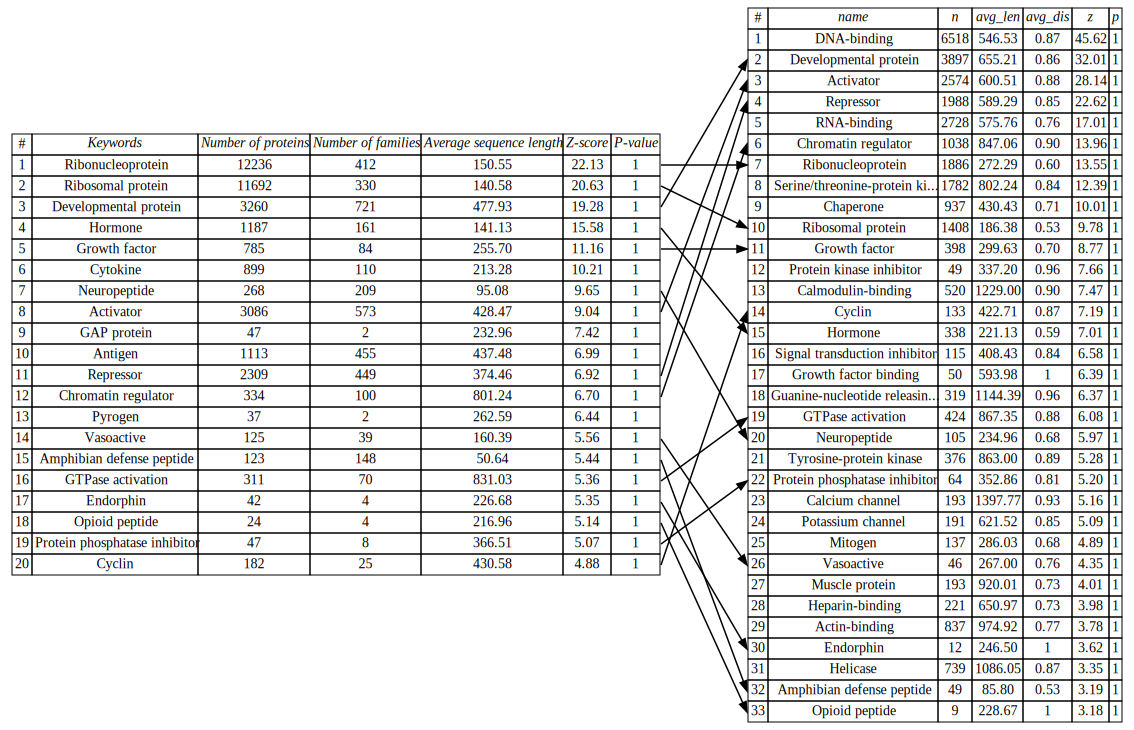

In [525]:


G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='false',nodesep=0, ranksep=1 )
G.add_node("A", label=df2html(top20dis2007), shape='none')
G.add_node("B", label=df2html(top20dis), shape='none')

ports = set.intersection( set(top20dis2007.Keywords),  set(top20dis.name) )
for port in ports:
    G.add_edge('A', 'B', tailport=port+'_right', headport=port+'_left', penwidth=1.5)

# for i,(_, *xs) in enumerate(top20dis2007.itertuples()):
#     name = xs[0]
#     G.add_node(name, label='', shape='point', )
#     G.add_edge(name, 'A', headport=name+'_left')


   
#print(G)
G.layout(prog='dot')
#G.draw('plots/KWtop20dis.pdf', format='pdf')
display.display_svg(G.draw(format='svg'), raw=True)

In [25]:
top20ord2007 = pd.read_csv('data/IN/top20ord2007.csv')
top20ord = Fj_kw_valid.sort_values('z', ascending=True) [:22]

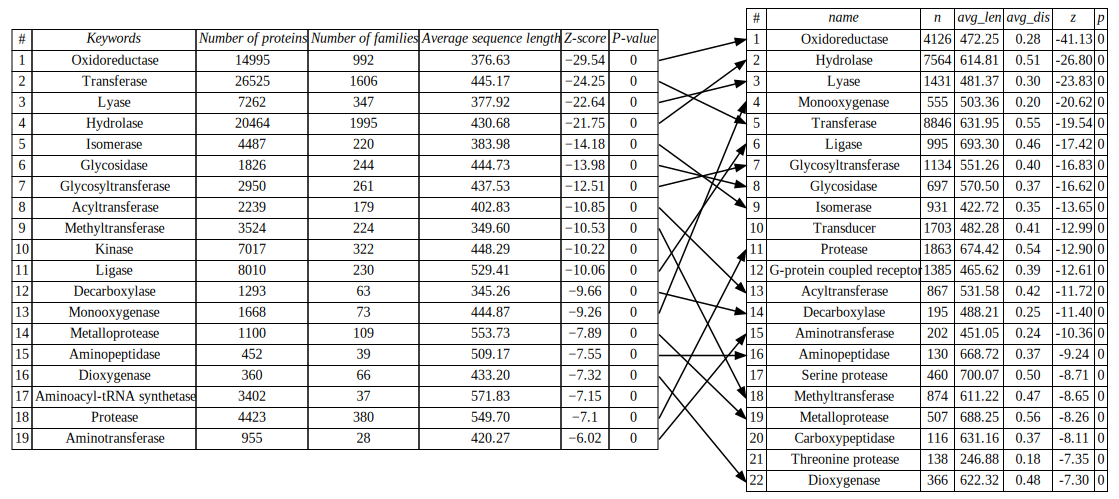

In [574]:
G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='false',nodesep=0, ranksep=1 )
G.add_node("A", label=df2html(top20ord2007), shape='none')
G.add_node("B", label=df2html(top20ord), shape='none')

ports = set.intersection( set(top20ord2007.Keywords),  set(top20ord.name) )
for port in ports:
    G.add_edge('A', 'B', tailport=port+'_right', headport=port+'_left',  penwidth=1.5)
    
#print(G)
G.layout(prog='dot')
G.draw('plots/KWtop20ord.pdf', format='pdf')
display.display_svg(G.draw(format='svg'), raw=True)

****

In [462]:
Fj_kw_stat_random = calc_stat(Fj_kw_raw, PL_random)

100%|██████████| 186/186 [00:10<00:00, 17.63it/s]


In [468]:
Fj_kw_valid_random = (Fj_kw_stat_random.query(' p<0.05 or p>0.95')
                                       .sort_values('z', ascending=False))


## Razlike izmedju Fj i Fj_random

In [612]:
Fjcmp = Fj_kw_valid.query('n>19').merge(Fj_kw_valid_random.query('n>19'), on='name', suffixes=('', '_r'), how='outer')
new_names = set( Fjcmp[Fjcmp.n.isnull()].name )
missing_names = set( Fjcmp[Fjcmp.n_r.isnull()].name )
Fj_kw_new = Fj_kw_valid_random[ Fj_kw_valid_random.name.isin(new_names) ]
Fj_kw_missing = Fj_kw_valid[ Fj_kw_valid.name.isin(missing_names) ]

In [627]:
Fjcmp['z_dif'] = Fjcmp.z - Fjcmp.z_r
Fjcmp[['name', 'avg_dis', 'z', 'z_r','z_dif']].query('z_dif>2 | z_dif<-2').sort_values('z_dif', ascending=False)

,name,avg_dis,z,z_r,z_dif
90,Transferase,0.550305,-19.716646,-27.024017,7.307371
93,Hydrolase,0.514014,-26.994267,-32.977360,5.983093
83,G-protein coupled receptor,0.390614,-12.447981,-18.149956,5.701975
84,Transducer,0.414563,-12.564667,-18.086269,5.521602
94,Oxidoreductase,0.282841,-41.350137,-46.562742,5.212604
71,Receptor,0.593458,-7.093591,-11.807126,4.713535
91,Monooxygenase,0.198198,-20.286297,-24.446405,4.160108
88,Glycosyltransferase,0.398589,-17.038265,-21.108469,4.070204
85,Protease,0.538916,-13.196874,-16.002457,2.805583
0,DNA-binding,0.871126,46.904973,44.319485,2.585488


In [629]:
G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='false',nodesep=0, ranksep=1 )
G.add_node("valid", label=df2html(Fj_kw_valid.query("n>19")), shape='none')
G.add_node("random", label=df2html(Fj_kw_valid_random.query("n>19")), shape='none')


ports = set.intersection( set(Fj_kw_valid.query("n>19").name),  set(Fj_kw_valid_random.query("n>19").name) )
for port in ports:
    G.add_edge('valid', 'random', tailport=port+'_right', headport=port+'_left', penwidth=1.5)
    
   
#print(G)
G.layout(prog='dot')
#G.draw('plots/KW_random.pdf', format='pdf')
#display.display_svg(G.draw(format='svg'), raw=True)

------

# GO

In [11]:
%run parsers/obo_parser.py 

In [12]:
term2prot = sql(r"""
select go, array_agg(ac) as proteins
     
from valid_proteins
    join prot2go on ac=prot
    join goterms on goterms.id=prot2go.go

where true
  and goterms.namespace = 'MF' -- Molecular function
  and valid_proteins.len >= 40

group by go
""")
term2prot.head()

,proteins
go,
GO:0000006,"[O94639, P39832, P32804]"
GO:0000007,[Q12436]
GO:0000009,"[Q9BV10, P23642, Q9USD4, O13640, P53730, P5010..."
GO:0000010,"[P18900, Q5T2R2, Q86YH6, Q33DR2, Q33DR3]"
GO:0000014,"[P13458, P49959, P0AG76, Q61216, Q47152, Q9JIM..."


In [13]:
import json
with open("data/IN/go.json", "r") as obo_file:
    term_list = [Term(t['id'], t) for t in json.load(obo_file)]
    term_dict = {term.id: term for term in term_list}
    
    def get_terms(id_list):
        return [ term_dict[term_id] for term_id in id_list if term_id in term_dict]
    
    for t in term_list:
        t.children = []
        t.prot_direct = set()

    for t in term_list:
        for parent in get_terms(t.is_a):
            parent.children.append(t)

In [14]:
for term_id, proteins in term2prot.itertuples():
    t = term_dict.get(term_id)
    t.prot_direct = set(proteins)


In [15]:
MF_leaf_nodes = [t for t in term_list if  t.children==[] and t.namespace_short() == 'MF']
len(MF_leaf_nodes)

10019

### Topoloski sort od listova

In [16]:
from collections import deque

In [17]:
for t in term_list:
    t.proteins = set(t.prot_direct) # moramo svaki put da ponistimo
    t.dependency_number = len(t.children)

working_que = deque(MF_leaf_nodes)

j = 0 # koliko novih nodova smo dodali
while len(working_que):
    t = working_que.pop()

    if len(t.proteins) > 900_000:
        continue
        
#    if t.replaced_by:
        #print(t.proteins) # ovi nemaju anotacije
    
    for parent in get_terms(t.is_a):
        parent.proteins |= t.proteins
        parent.dependency_number -= 1

        if parent.dependency_number == 0:
            j +=1
            working_que.append(parent)
    
j

2082

In [18]:
max(len(t.proteins) for t in term_list)

57460

In [19]:
valid_terms = [t for t in term_list if t.dependency_number==0 and len(t.proteins) >= 20]
len(valid_terms)

1781

In [20]:
prot_stat = sql(r"""
select ac, len, dis40
from valid_proteins        
""")
prot_stat = {k:tuple(v.values()) for k, v in prot_stat.to_dict(orient='index').items() }
for k, v in prot_stat.items():
    print(k, v)
    break

A2AC93 (623, True)


In [21]:
Fj_go_raw = []
for t in valid_terms:
    prot_dis40 = np.array( [prot_stat[prot][1]for prot in t.proteins ] )
    prot_len = np.array( [prot_stat[prot][0]for prot in t.proteins ] )
    Fj_go_raw.append( (t.id, t.name, len(prot_len), prot_len.mean(), prot_dis40.mean(), prot_len) )
    #break
    
Fj_go_raw = pd.DataFrame(Fj_go_raw, columns=['go', 'name', 'n', 'avg_len', 'avg_dis', 'length_list']).set_index('go')  
Fj_go_raw.head()

,name,n,avg_len,avg_dis,length_list
go,,,,,
GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,39,676.025641,0.794872,"[692, 213, 759, 897, 1048, 298, 708, 649, 877,..."
GO:0000026,"alpha-1,2-mannosyltransferase activity",35,469.800000,0.371429,"[427, 446, 555, 386, 597, 378, 522, 577, 378, ..."
GO:0000030,mannosyltransferase activity,144,536.263889,0.340278,"[497, 458, 493, 423, 886, 755, 382, 654, 378, ..."
GO:0000036,acyl carrier activity,21,514.190476,0.476190,"[136, 110, 1876, 4924, 115, 156, 78, 112, 1414..."
GO:0000049,tRNA binding,247,566.348178,0.574899,"[414, 163, 978, 482, 684, 298, 581, 156, 570, ..."


In [69]:
Fj_go_stat = calc_stat(Fj_go_raw, PL)

100%|██████████| 1781/1781 [01:50<00:00, 16.15it/s]


In [99]:
#Fj_go_stat.to_csv('data/tmp/FJ_go_stat.csv')

In [88]:
Fj_go_stat = pd.read_csv('data/tmp/FJ_go_stat.csv', index_col='go')

In [89]:
Fj_go_stat.head()

,name,n,avg_len,avg_dis,z,p
go,,,,,,
GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,39,676.025641,0.794872,1.155854,0.919
GO:0000026,"alpha-1,2-mannosyltransferase activity",35,469.800000,0.371429,-3.060547,0.003
GO:0000030,mannosyltransferase activity,144,536.263889,0.340278,-8.262304,0.000
GO:0000036,acyl carrier activity,21,514.190476,0.476190,0.318457,0.724
GO:0000049,tRNA binding,247,566.348178,0.574899,-2.388209,0.014


In [90]:
Fj_go_valid = (Fj_go_stat.query(' p<0.05 or p>0.95')
                         .sort_values('z', ascending=False))
Fj_go_valid_dis = Fj_go_valid.query('p>0.5')
Fj_go_valid_ord = Fj_go_valid.query('p<0.5')
Fj_go_valid.head()

,name,n,avg_len,avg_dis,z,p
go,,,,,,
GO:0140110,transcription regulator activity,5322,523.136603,0.903420,46.522005,1.0
GO:0003677,DNA binding,8254,574.894354,0.856312,46.125225,1.0
GO:0003700,DNA binding transcription factor activity,4214,492.293071,0.917181,45.648061,1.0
GO:0003676,nucleic acid binding,13598,563.963524,0.798867,45.156866,1.0
GO:0043565,sequence-specific DNA binding,3836,536.947080,0.920490,41.771462,1.0


In [91]:
print(f"""
Od ukupno {len(Fj_go_stat)} MF kljucnih reci, {len(Fj_go_valid)} su statisticki znacajne
od cega su {len(Fj_go_valid_ord)} uredjene, a {len(Fj_go_valid_dis)} neuredjene.
""")


Od ukupno 1781 MF kljucnih reci, 1315 su statisticki znacajne
od cega su 699 uredjene, a 616 neuredjene.



In [92]:
len(Fj_go_valid_dis)

616

In [93]:
from py2neo import Graph
g = Graph("http://localhost:7474/")
data = g.run('MATCH (m)-[:map_to]->(t:MF) return m.name as kw, t.name as go').data()
kw2go = { d['kw']: d['go'] for d in data}
go2kw = { d['go']: d['kw'] for d in data}

In [94]:
import pygraphviz as pgv
from IPython import display
from pprint import pprint

In [95]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('viridis') )

    
def encode_color(rgb_color):
    cs = rgb_color[:3]
    cs = [hex(int(c*256))[2:].upper() for c in cs]
    cs = [ c if len(c)==2 else "0"+c for c in cs]
    return "#"+"".join(cs)

def get_color(x):
    return encode_color( scalarMap.to_rgba(x) )

get_color(1), get_color(1)

('#FEE724', '#FEE724')

In [96]:
def arange_unconected_nodes(G, k):

    from itertools import zip_longest, repeat
    notNone = lambda x: x is not None

    not_conected_nodes = (n for n, d1, d2 in zip(G.nodes(), G.in_degree(), G.out_degree()) if d1==0 and d2==0)
    rows = [x for x in zip_longest(*repeat(not_conected_nodes, k)) ]
    for xs in rows:
        xs = list(filter(notNone, xs))
        for x, y in zip(xs, xs[1:]):
            G.add_edge(x,y, style='invis')
            
    for xs in zip(*rows):
        xs = list(filter(notNone, xs))
        for x, y in zip(xs, xs[1:]):
            G.add_edge(x,y, style='invis')
            


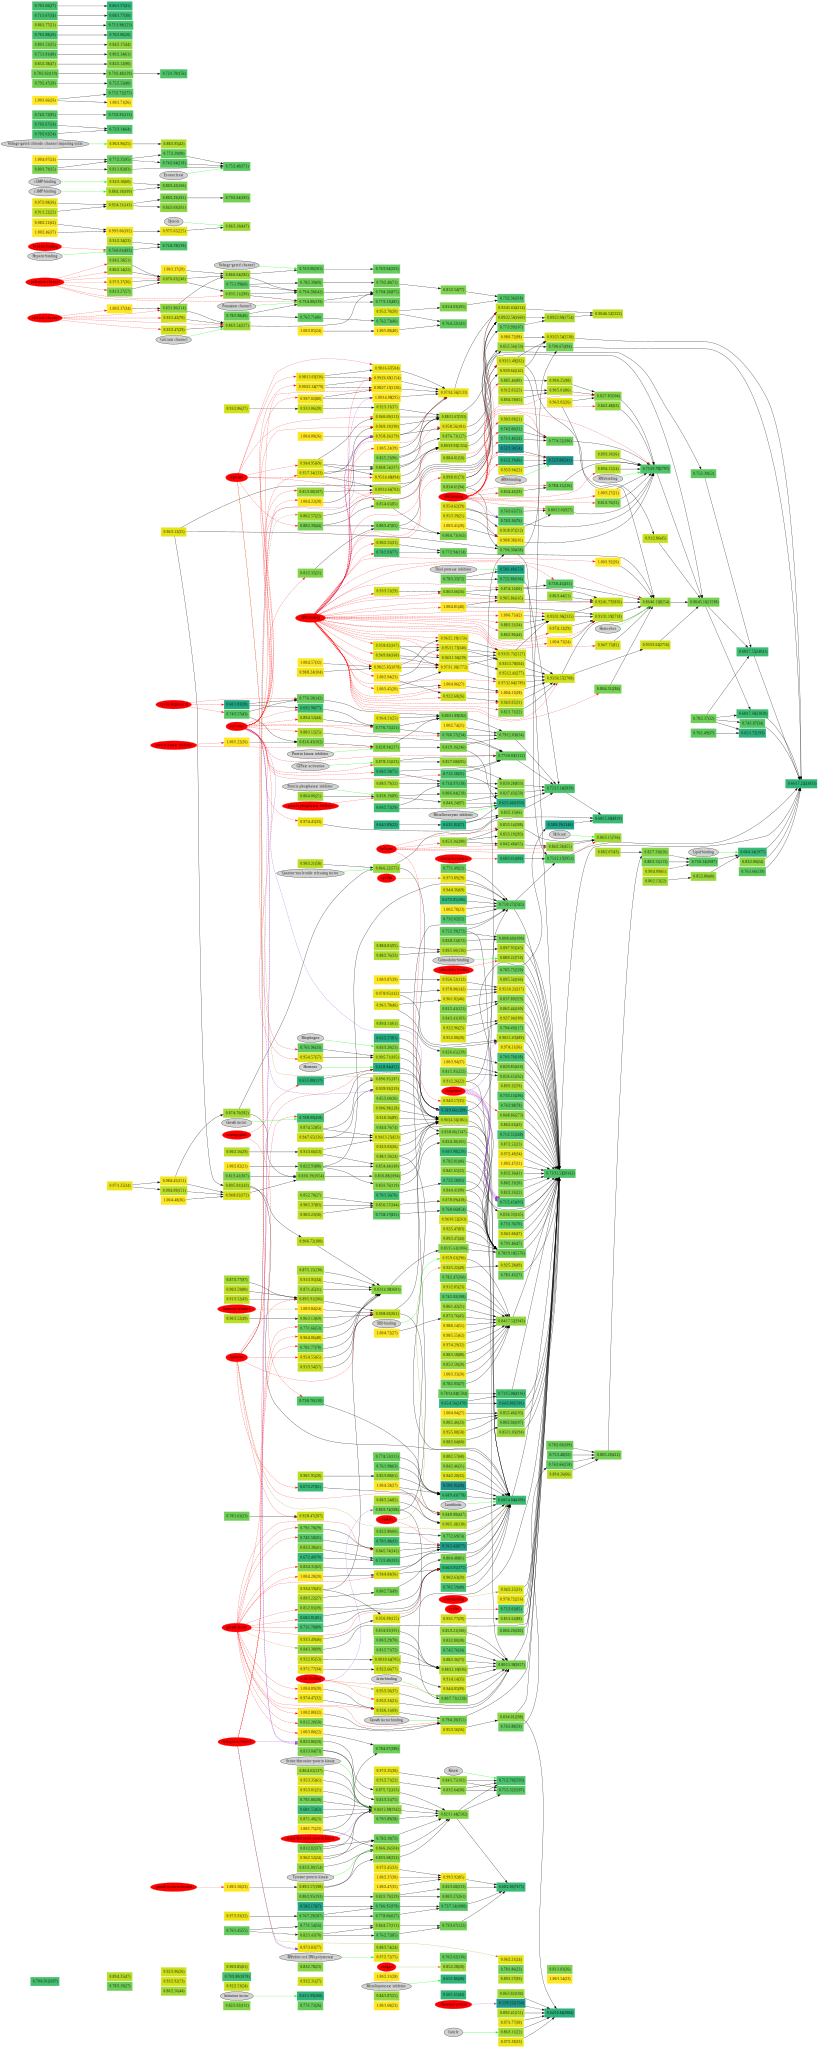

In [106]:
G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='true',nodesep=0.05, ranksep=1)
G.node_attr['style']='filled'

Fj_df = Fj_go_valid_dis
Fj_df_set = set(Fj_df.index)

import html

for go, *xs in Fj_df.itertuples():
    name, n, avg_len, avg_dis, z, p = xs
    t = term_dict[go]
    #label = f"%0.2f | %0.2f ({n})" %(avg_dis, z)
    synonyms = '&#013;'.join(["%s:%s"%(html.escape(s_name), t) for s_name, t, _ in t.synonym])
    definition = f"name: {t.name} ({t.id}) &#013; def: {html.escape(t.definition[0])}  {html.escape(str(t.definition[1:]))}&#013;synonyms:&#013;{synonyms}"
    
    label = (f'<<table border="0" cellborder="0" cellspacing="0" href="https://www.ebi.ac.uk/QuickGO/GTerm?id={t.id}" TOOLTIP="{definition}"> '
            '<tr><td>%0.2f/</td> <td>%0.2f</td> <td>(%d)</td> </tr> </table>>') %( avg_dis, z, n)

    G.add_node(name, label=label, shape='rectangle', color=get_color(avg_dis), fontcolor='#000000')#, labelURL="https://www.ebi.ac.uk/QuickGO/GTerm?id="+t.id)
    for p_id in t.is_a:
        if p_id in Fj_df_set:
            G.add_edge(name, term_dict[p_id].name)
            
arange_unconected_nodes(G, 6)
           

import re
#words = ["helix-loop-helix","zinc finger","leucine zipper","14-3-3"]

words = set(top20dis.name) | set(top20dis2007.Keywords)
words = words | {w.replace("-", " ") for w in words}


expresion = re.compile(f"({'|'.join(words)})[^ ,.)]*", re.I)

for go, *xs in Fj_df.itertuples():
    name, n, avg_len, avg_dis, z, p = xs
    definition = term_dict[go].definition[0]
    synonyms = term_dict[go].synonym

    match = expresion.search(name)
    if match:
        G.add_node(" "+match.group(0), color="#ff0000")
        G.add_edge(" "+match.group(0), name, color="#ff0000ee", style='dashed')
    
    if not match:
        for synonym, _, _ in synonyms:
            match = expresion.search(synonym)
            if match:
                G.add_node(" "+match.group(0), color="#ff0000")
                G.add_edge(" "+match.group(0), name, color="#9932CC", style='dashed')            

    if not match:
        match = expresion.search(definition)
        if match:
            G.add_node(" "+match.group(0), color="#ff0000")
            G.add_edge(" "+match.group(0), name, color="#aa8800", style='dashed')
            
    if name in go2kw:
        G.add_edge(" "+go2kw[name], name, color="#00ff00")
        

    
#print(G)
G.layout(prog='dot')
G.draw('data/OUT/disorder.svg', format='svg')
display.display_svg(G.draw(format='svg'), raw=True)

In [113]:
words = ["guanyl-nucleotide exchange factor activity"]
expresion = re.compile(f"(^{'|'.join(words)})[^ ,.)]*", re.I)

In [114]:
for t in valid_terms:
    if expresion.search(t.name):
        print(t.name)

guanyl-nucleotide exchange factor activity


In [115]:
for t in term_list:
    if expresion.search(t.name):
        print(t.name)
        print(f'"{t.definition[0]}"')
        print()

guanyl-nucleotide exchange factor activity
"Stimulates the exchange of guanyl nucleotides associated with a GTPase. Under normal cellular physiological conditions, the concentration of GTP is higher than that of GDP, favoring the replacement of GDP by GTP in association with the GTPase."



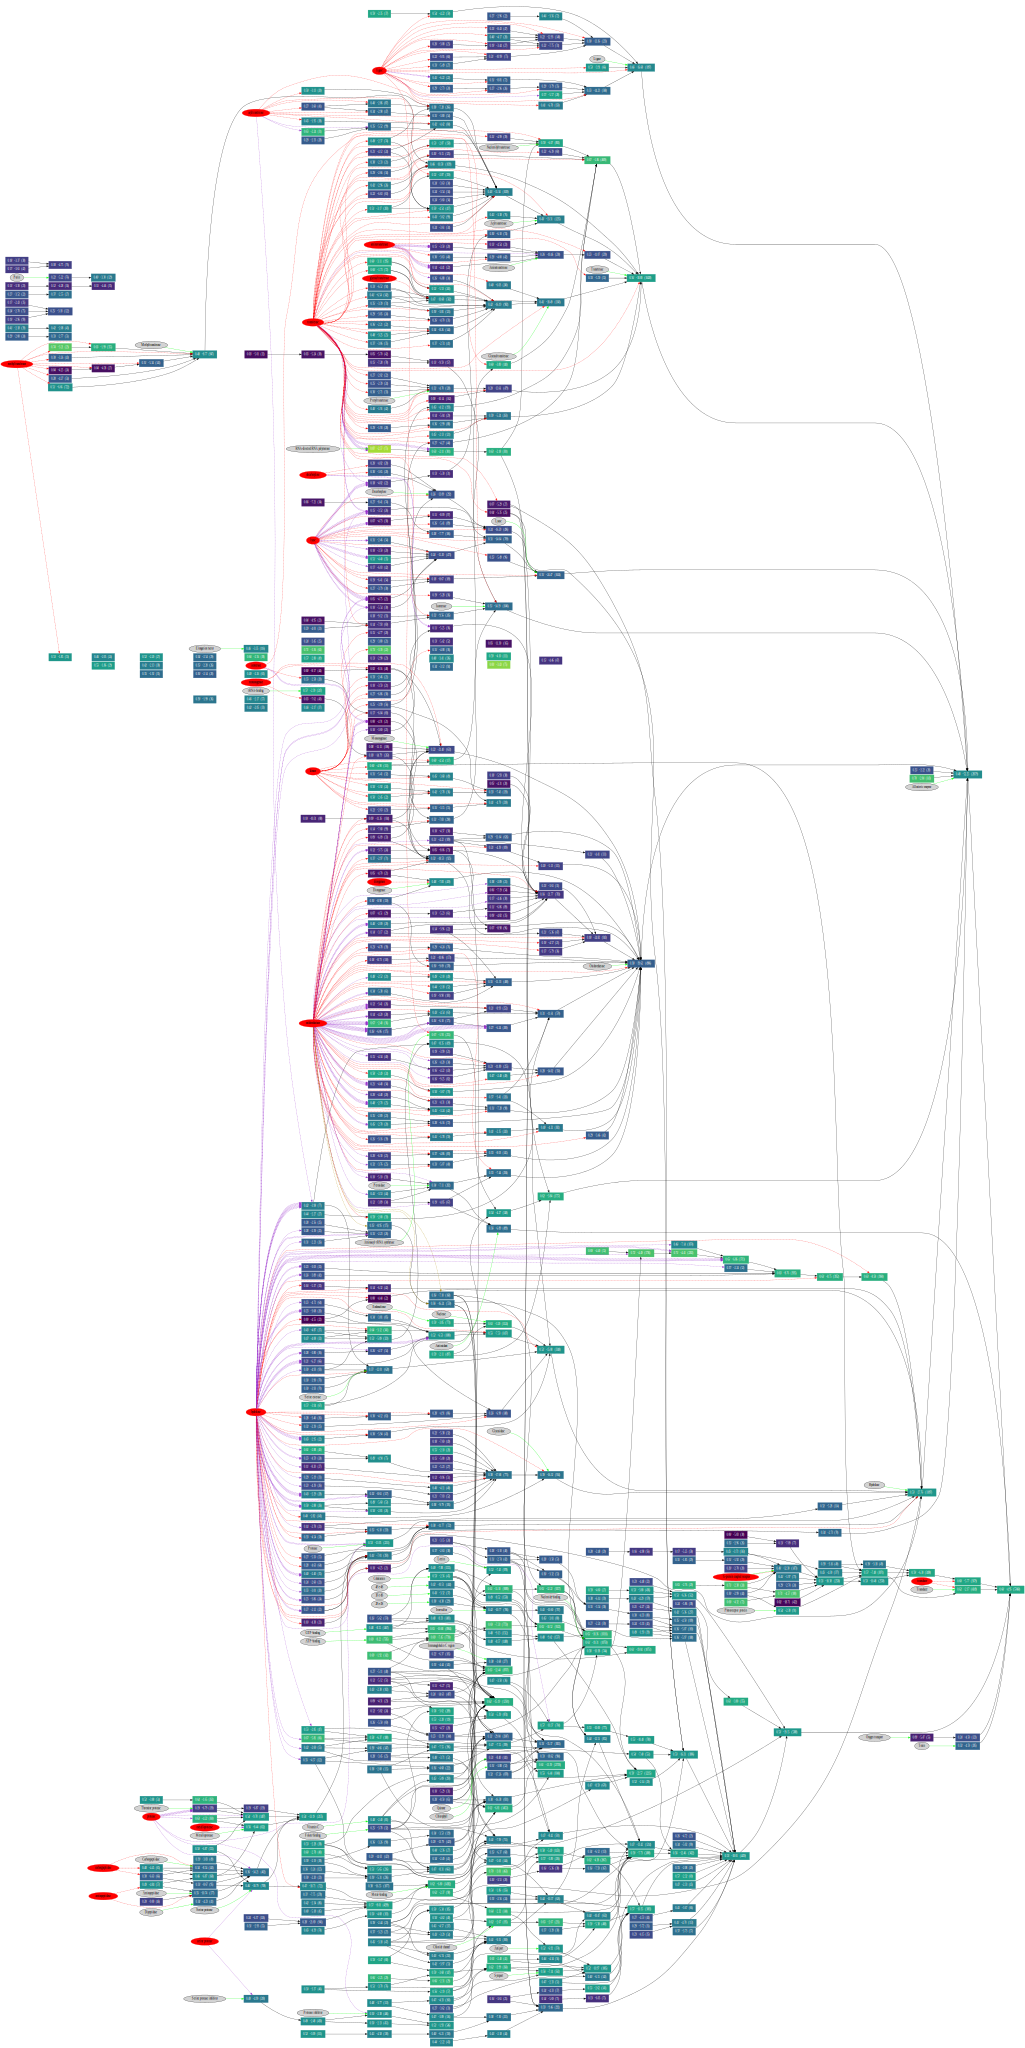

In [83]:
G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='true',nodesep=0.05, ranksep=1)
G.node_attr['style']='filled'

Fj_df = Fj_go_valid_ord
Fj_df_set = set(Fj_df.index)

import html

for go, *xs in Fj_df.itertuples():
    name, n, avg_len, avg_dis, z, p = xs
    t = term_dict[go]
    #label = f"%0.2f | %0.2f ({n})" %(avg_dis, z)
    synonyms = '&#013;'.join(["%s:%s"%(html.escape(s_name), t) for s_name, t, _ in t.synonym])
    definition = f"name: {t.name} ({t.id}) &#013; def: {html.escape(t.definition[0])}  {html.escape(str(t.definition[1:]))}&#013;synonyms:&#013;{synonyms}"
    label = (f'<<table border="0" cellborder="0" cellspacing="0" href="https://www.ebi.ac.uk/QuickGO/GTerm?id={t.id}" TOOLTIP="{definition}"> '
            '<tr><td>%0.2f/</td> <td>%0.2f</td> <td>(%d)</td> </tr> </table>>') %( avg_dis, z, n)

    G.add_node(name, label=label, shape='rectangle', color=get_color(avg_dis), fontcolor='#ffffff')#, labelURL="https://www.ebi.ac.uk/QuickGO/GTerm?id="+t.id)
    for p_id in t.is_a:
        if p_id in Fj_df_set:
            G.add_edge(name, term_dict[p_id].name)

arange_unconected_nodes(G, 5)


import re
#words += ["helix-loop-helix","zinc finger","leucine zipper","14-3-3"]

words = set(top20ord.name) | set(top20ord2007.Keywords)
words = words | {w.replace("-", " ") for w in words}
expresion = re.compile(f"({'|'.join(words)})[^ ,.)]*", re.I)

for go, *xs in Fj_df.itertuples():
    name, n, avg_len, avg_dis, z, p = xs
    term = term_dict[go]

    match = expresion.search(name)
    if match:
        G.add_node(" "+match.group(0), color="#ff0000")
        G.add_edge(" "+match.group(0), name, color="#ff0000ee", style='dashed')
    
    if not match:
        for synonym, _, _ in term.synonym:
            match = expresion.search(synonym)
            if match:
                G.add_node(" "+match.group(0), color="#ff0000")
                G.add_edge(" "+match.group(0), name, color="#9932CC", style='dashed')            

    if not match:
        match = expresion.search(term.definition[0])
        if match:
            G.add_node(" "+match.group(0), color="#ff0000")
            G.add_edge(" "+match.group(0), name, color="#aa8800", style='dashed')
            
    if name in go2kw:
        G.add_edge(" "+go2kw[name], name, color="#00ff00")
    
    
#print(G)
G.layout(prog='dot')
G.draw('data/OUT/order.svg', format='svg')
display.display_svg(G.draw(format='svg'), raw=True)